In [1]:
import pandas as pd

penguins = pd.read_csv("../datasets/penguins.csv")

columns = ["Body Mass (g)", "Flipper Length (mm)", "Culmen Length (mm)"]
target_name = "Species"

# Remove lines with missing values for the columns of interest
penguins_non_missing = penguins[columns + [target_name]].dropna()

data = penguins_non_missing[columns]
target = penguins_non_missing[target_name]

In [2]:
target.nunique()

3

In [3]:
data.describe()

,Body Mass (g),Flipper Length (mm),Culmen Length (mm)
count,342.000000,342.000000,342.000000
mean,4201.754386,200.915205,43.921930
std,801.954536,14.061714,5.459584
min,2700.000000,172.000000,32.100000
25%,3550.000000,190.000000,39.225000
50%,4050.000000,197.000000,44.450000
75%,4750.000000,213.000000,48.500000
max,6300.000000,231.000000,59.600000


In [4]:
target.value_counts()


Species
Adelie Penguin (Pygoscelis adeliae)          151
Gentoo penguin (Pygoscelis papua)            123
Chinstrap penguin (Pygoscelis antarctica)     68
Name: count, dtype: int64

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])


In [10]:
from sklearn.model_selection import cross_validate

model.set_params(preprocessor=StandardScaler(), classifier__n_neighbors=5)
cv_results_ss_5 = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy"
)
cv_results_ss_5["test_score"].mean(), cv_results_ss_5["test_score"].std()

(0.9521978021978021, 0.0399020975957868)

In [15]:
model.set_params(preprocessor=StandardScaler(), classifier__n_neighbors=51)
cv_results_ss_51 = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy"
)
cv_results_ss_51["test_score"].mean(), cv_results_ss_51["test_score"].std()

(0.9418803418803419, 0.03890547525064432)

5-NN is strictly better than 51-NN for 4 CV iterations out of 10.


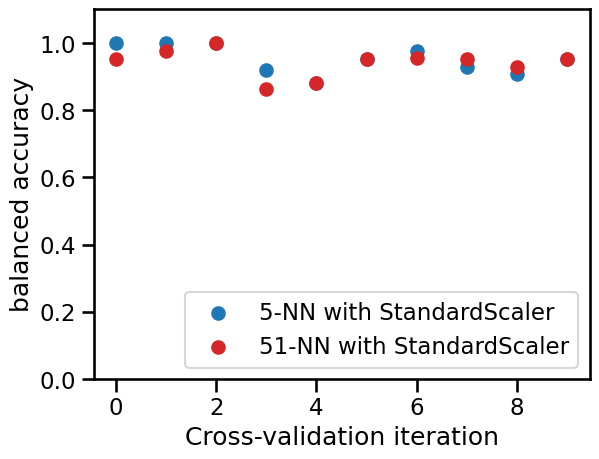

In [16]:
import numpy as np
import matplotlib.pyplot as plt

test_score_ss_5 = cv_results_ss_5['test_score']
test_score_ss_51 = cv_results_ss_51['test_score']

indices = np.arange(len(test_score_ss_5))
plt.scatter(
    indices,
    test_score_ss_5,
    color="tab:blue",
    label="5-NN with StandardScaler",
)
plt.scatter(
    indices,
    test_score_ss_51,
    color="tab:red",
    label="51-NN with StandardScaler",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    "5-NN is strictly better than 51-NN for "
    f"{sum(test_score_ss_5 > test_score_ss_51)}"
    " CV iterations out of 10."
)

In [17]:
model.set_params(preprocessor=StandardScaler(), classifier__n_neighbors=101)
cv_results_ss_101 = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy"
)
cv_results_ss_101["test_score"].mean(), cv_results_ss_101["test_score"].std()

(0.8766422466422465, 0.04161841544181347)

5-NN is strictly better than 101-NN for 10 CV iterations out of 10.


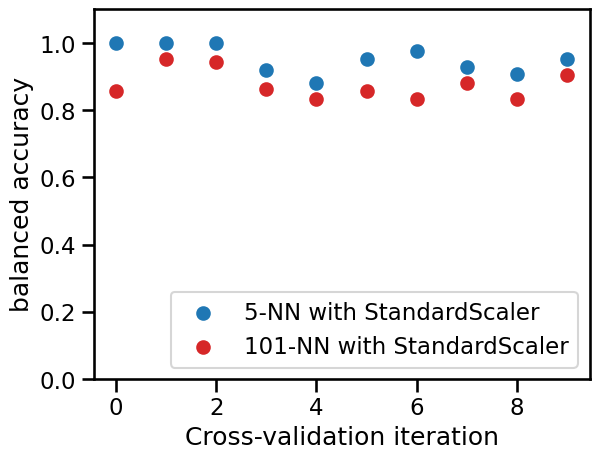

In [18]:
test_score_ss_101 = cv_results_ss_101['test_score']

plt.scatter(
    indices,
    test_score_ss_5,
    color="tab:blue",
    label="5-NN with StandardScaler",
)
plt.scatter(
    indices,
    test_score_ss_101,
    color="tab:red",
    label="101-NN with StandardScaler",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    "5-NN is strictly better than 101-NN for "
    f"{sum(test_score_ss_5 > test_score_ss_101)}"
    " CV iterations out of 10."
)

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


all_preprocessors = [
    None,
    StandardScaler(),
    MinMaxScaler(),
    QuantileTransformer(n_quantiles=100),
    PowerTransformer(method="box-cox"),
]

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "preprocessor": all_preprocessors,
    "classifier__n_neighbors": [5, 51, 101],
}

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=10,
).fit(data, target)
results = pd.DataFrame(grid_search.cv_results_).sort_values(
    by="rank_test_score", ascending=True
)
# convert the name of the preprocessor for later display
results["param_preprocessor"] = results["param_preprocessor"].apply(
    lambda x: x.__class__.__name__ if x is not None else "None"
)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_preprocessor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.003717,0.000090,0.004954,0.000106,5,StandardScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,1.000000,1.000000,0.918803,0.882540,0.952381,0.977778,0.930159,0.907937,0.952381,0.952198,0.039902,1
2,0.003677,0.000281,0.005038,0.000349,5,MinMaxScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.952381,1.000000,0.944444,0.882540,0.930159,0.955556,0.952381,0.907937,0.952381,0.947778,0.034268,2
3,0.005457,0.000578,0.005601,0.000691,5,QuantileTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",0.952381,0.926740,1.000000,0.918803,0.904762,1.000000,0.977778,0.930159,0.907937,0.952381,0.947094,0.033797,3
4,0.007341,0.000655,0.005471,0.000477,5,PowerTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.930159,0.907937,1.000000,0.946960,0.047387,4
6,0.003717,0.000157,0.005279,0.000210,51,StandardScaler,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.952381,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.952381,0.930159,0.952381,0.941880,0.038905,5
8,0.005199,0.000370,0.005529,0.000368,51,QuantileTransformer,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.857143,0.952381,1.000000,0.863248,0.904762,0.904762,0.977778,0.930159,0.930159,0.952381,0.927277,0.043759,6
9,0.007254,0.000448,0.005590,0.000054,51,PowerTransformer,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.977778,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.922833,0.047883,7
7,0.003644,0.000127,0.005408,0.000387,51,MinMaxScaler,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.952381,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.920293,0.045516,8
11,0.003875,0.000374,0.005761,0.000363,101,StandardScaler,"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.952381,0.944444,0.863248,0.834921,0.857143,0.834921,0.882540,0.834921,0.904762,0.876642,0.041618,9
12,0.003566,0.000079,0.005455,0.000073,101,MinMaxScaler,"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.857143,0.944444,0.863248,0.834921,0.857143,0.765079,0.904762,0.834921,0.904762,0.862357,0.046244,10


5-NN with StandardScaler is strictly better than 5-NN with MinMaxScaler for 3 CV iterations out of 10.
5-NN with StandardScaler is strictly better than 5-NN with QuantileTransformer for 2 CV iterations out of 10.
5-NN with StandardScaler is strictly better than 5-NN with PowerTransformer for 3 CV iterations out of 10.


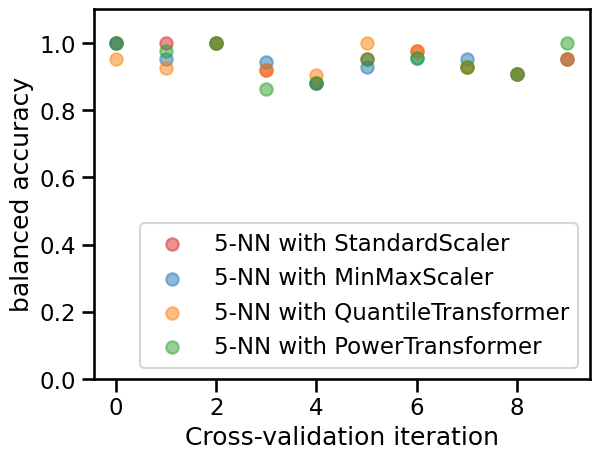

In [22]:
reference_model = results.iloc[0]
other_models = results.iloc[1:4]
cv_score_columns = results.columns[results.columns.str.startswith("split")]
score_reference_model = reference_model[cv_score_columns]

fig, ax = plt.subplots()
ax.scatter(
    indices,
    score_reference_model,
    color="tab:red",
    alpha=0.5,
    label=f"{reference_model['param_classifier__n_neighbors']}-NN with "
          f"{reference_model['param_preprocessor']}",
)

for idx, other_model in other_models.iterrows():
    score_other_model = other_model[cv_score_columns]
    ax.scatter(
    indices,
    score_other_model,
    alpha=0.5,
    label=f"{other_model['param_classifier__n_neighbors']}-NN with "
          f"{other_model['param_preprocessor']}",
    )
    print(
        f"{reference_model['param_classifier__n_neighbors']}-NN with "
        f"{reference_model['param_preprocessor']} is strictly better than "
        f"{other_model['param_classifier__n_neighbors']}-NN with "
        f"{other_model['param_preprocessor']} for "
        f"{sum(score_reference_model > score_other_model)} CV iterations "
        f"out of 10."
    )
ax.set_ylim((0, 1.1))
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("balanced accuracy")
_ = ax.legend(loc="lower right")

5-NN with StandardScaler is strictly better than 51-NN with StandardScaler for 4 CV iterations out of 10.


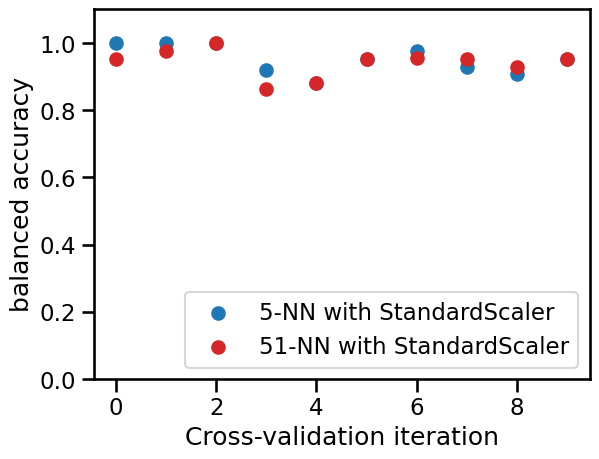

In [23]:
model_ss_51 = results.iloc[4]
score_model_ss_51 = model_ss_51[cv_score_columns]

fig, ax = plt.subplots()
ax.scatter(
    indices,
    score_reference_model,
    color="tab:blue",
    label=f"{reference_model['param_classifier__n_neighbors']}-NN with "
          f"{reference_model['param_preprocessor']}",
)
ax.scatter(
    indices,
    score_model_ss_51,
    color="tab:red",
    label=f"{model_ss_51['param_classifier__n_neighbors']}-NN with "
          f"{model_ss_51['param_preprocessor']}",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    f"5-NN with StandardScaler is strictly better than 51-NN with StandardScaler for "
    f"{sum(score_reference_model > score_model_ss_51)} "
    "CV iterations out of 10."
)

51-NN with StandardScaler is strictly better than 101-NN with StandardScaler for 9 CV iterations out of 10.


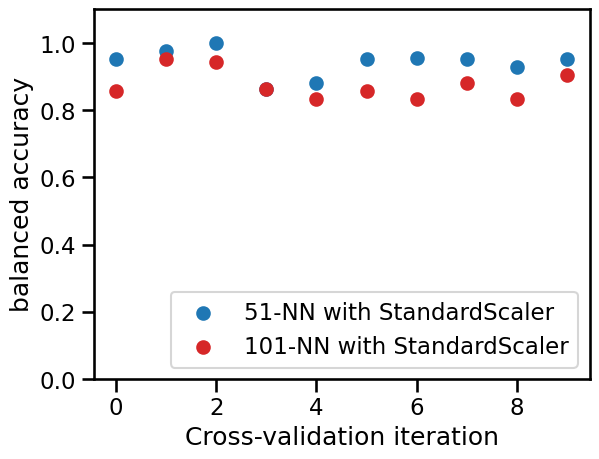

In [24]:
model_ss_101 = results.iloc[8]
score_model_ss_101 = model_ss_101[cv_score_columns]

fig, ax = plt.subplots()
ax.scatter(
    indices,
    score_model_ss_51,
    color="tab:blue",
    label=f"{model_ss_51['param_classifier__n_neighbors']}-NN with "
          f"{model_ss_51['param_preprocessor']}",
)
ax.scatter(
    indices,
    score_model_ss_101,
    color="tab:red",
    label=f"{model_ss_101['param_classifier__n_neighbors']}-NN with "
          f"{model_ss_101['param_preprocessor']}",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    f"51-NN with StandardScaler is strictly better than 101-NN with StandardScaler for "
    f"{sum(score_model_ss_51 > score_model_ss_101)} "
    "CV iterations out of 10."
)

In [25]:
cv_results = cross_validate(
    grid_search,
    data,
    target,
    cv=10,
    n_jobs=2,
    scoring="balanced_accuracy",
    return_estimator=True,
)
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']

print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.943 +/- 0.038


In [26]:
for estimator in cv_results["estimator"]:
    print(estimator.best_params_)

{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
